## **Evaluation and Calibration of posteriors**

In this notebook we import the predicted test set posteriors, make posterior plots, as well as calibration plots.

In [19]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

Import some basic packages

In [2]:
# Import basic packages
import numpy as np

# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chainconsumer
from chainconsumer import ChainConsumer

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

### **Import data**

In [3]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Define the data path
DATA_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Datasets/'

# IMAGE PATH
IMG_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Plots/'

# MODELS PATH
MODELS_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Saved_Models/'

In [27]:
y_cosmo = np.float64(np.load(DATA_PATH+"y_maps_Cosmogrid_100k.npy"))

In [6]:
# Get omega and sigma 8
#y_Omega = y_cosmo[:,0];y_sigma_8 = y_cosmo[:,3]

# Labels for two cosmological parameters 
#y_cosmo_2 = np.stack([y_Omega,y_sigma_8],axis=-1)

y_cosmo_2 = y_cosmo[:,:5]

# Split into training, validation, test sets
y_train  = y_cosmo_2[:80000]
y_val = y_cosmo_2[80000:90000]
y_test = y_cosmo_2[90000:]

We actually keep the first 1000 examples from the test set, for which we have samples their posterior.

In [7]:
y_keep = y_test[:1000]

Import samples

In [35]:
#samples_NPE = np.load(MODELS_PATH+'samples_test_SBI_NOISY.npy')
#samples_BNN = np.load(MODELS_PATH+'samples_test_BNN_NOISY.npy')

samples_NPE = np.load(MODELS_PATH+'samples_test_SBI_full_posterior.npy')
samples_BNN = np.load(MODELS_PATH+'samples_test_BNN_full_posterior.npy')

samples_NPE_NOISY = np.load(MODELS_PATH+'samples_test_SBI_full_posterior_NOISY.npy')
samples_BNN_NOISY = np.load(MODELS_PATH+'samples_test_BNN_full_posterior_NOISY.npy')

### Functions that can be used in the rest of the notebook.

Here we write some useful functions that can be used in the rest of the notebook to perform simular tasks multiple times.


- **Posterior plots**.

In [17]:
def plot_posteriors(train_set, samples_BNN, samples_SBI, y_true, plt_name, full_posterior=False):
  """
  Function that creates a ChainConsumer plot.
  INPUTS
  train_set: training set
  samples_BNN: posterior samples from the BNN model
  samples_SBI: posterior samples from the SBI/NPE model
  y_true: true value of the cosmological parameters describing the patch
  plt_name: (str) the name to be given to the output figure
  full_posterior: whether we plot the full posterior or only Omega_m-sigma_8
                  Defaults to false
  """
  
  if (full_posterior==False):
    params = ["$\Omega_m$", "$\sigma_8$"]
  else: 
    params = ["$\Omega_m$", "$H_0$", "$n_s$", "$\sigma_8$", "$w_0$"]

  
  # Make plots
  c = ChainConsumer()
  c.add_chain(train_set[:6000],parameters=params,name='Training set')
  c.add_chain(samples_BNN,parameters=params,name='BNN')
  c.add_chain(samples_SBI,parameters=params,name='NPE')

  # Configure plot
  c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
              usetex=True,
              legend_kwargs={"frameon":True, "fontsize":30}, kde=True)


  fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_true)

  #plt.tight_layout()
  plt.savefig(IMG_PATH+plt_name+".pdf")
  plt.show()

- **Calibration plots**

We define functions used to create the calibration plots.

For more information about the calibration plots and the equations implemented here see the relevant section on the draft, as well as arXiv: 2012.00042, section 2.3.3.

In [20]:
def mahalanobis_dist(param_vector, mean_vector, covariance):
  """
  Function that calculates the Mahalanobis distance.
  Inputs:
  Param vector: [n_samples, n_params]
  Mean vector: means of parameters, size [n_params]
  Covariance: covariance of the parameters, size [n_params,n_params]
  Output:
  The Mahalanobis distance
  """
  # Get number of samples and number of parameters
  n_samples, n_params = np.shape(param_vector)

  # Get inverse covariance
  inv_cov = np.linalg.inv(covariance)

  # Initialize vector of distances
  dist_vect = np.zeros(n_samples)
  # Populate
  for i in range(n_samples):
    diff_i = np.array(param_vector[i] - mean_vector)
    dist_vect[i] = np.sqrt(np.dot(diff_i.T,np.dot(inv_cov,diff_i)))

  return dist_vect 

In [21]:
def prob_coverage(sample, true_params, percentile_list):
  """
  Calculates the coveragge
  Inputs:
  sample: An array of shape [n_inst, n_sample, n_params],
          where: n_inst: the number of different isntances (examples/test set size) considered.
                 n_sample: the number of samples drawn from the posterior, for each 
                 test set example.
                 n_params: the number of cosmological parameters considered
  true_params: a list of shape [n_inst, n_params] with the ground truth values
  percentile_list: List of the percentile points for which we want to calcluate 
                   
  the probability coverage

  """
  # Get the number of instances, samples, and parameters
  n_inst, n_sample, n_params = np.shape(sample)

  
  #Initialize 
  prob_vol = np.zeros(n_inst)
  for i in range(n_inst):
    # Get array of samples of the i-th instance
    sample_i = sample[i,:,:]
    # Get mean vector and covariance matrix 
    mean = np.mean(sample_i,axis=0)
    cov = np.cov(sample_i,rowvar=False)

    # Get true parameters of the i-th instance
    true_params_i = true_params[i].reshape(1,len(true_params[i]))

    # Get Mahalanobis distances of the samples and the true value
    d_sample_i = mahalanobis_dist(sample_i,mean,cov)
    d_true_i = mahalanobis_dist(true_params_i,mean,cov)

    diff = d_sample_i - d_true_i
    prob_vol[i] = sum(diff<0)/n_sample
  # ==========================================
  # ==========================================
  
  n_perc = len(percentile_list)
  prob_cov = np.zeros(n_perc)

  for i in range(n_perc):
    prob_cov[i] = sum(prob_vol-percentile_list[i]<0)/n_inst

  return prob_cov

In [25]:
def make_calibration_plot(samples_BNN, samples_SBI, y_true, plt_name, plt_title=None):
  """
  Function used to easily plot the calibration curve.
  Inputs:
  samples_BNN: The test set samples we generated using BNN
  samples_SBI: The test set samples we generated using SBI
  y_true: vector of the ground truth values
  plt_name: (str) The name of the figure to be saved
  plt_title: (str) The title to be used in the plot. If None (default) no title 
             is used.
  """
  # Calculate the coverages by calling the functions above
  percentiles = np.linspace(0,1,50)
  prob_covs_SBI = prob_coverage(samples_SBI,y_true,percentiles)
  prob_covs_BNN = prob_coverage(samples_BNN,y_true,percentiles)


  # Now plot
  x = np.linspace(0,1,100)
  plt.figure(figsize=(6.5, 6.5))

  plt.plot(percentiles,prob_covs_BNN,linewidth=2.5,label='BNN')
  plt.plot(percentiles,prob_covs_SBI,linewidth=2.5,label='NPE')
  plt.plot(x,x,ls='--',linewidth=1.0,c='k')
  plt.grid(ls='--',alpha=0.6)

  # Configure appearance and titles
  plt.text(0.4,0.05,'Overconfident', fontsize=15)
  plt.text(0.02,0.85,'Underconfident',fontsize=15)

  if (plt_title!=None):
    plt.title(plt_title, fontsize=13)

  plt.xlabel('Fraction of posterior volume, $p_X$',fontsize=15)
  plt.ylabel('Fraction of maps with truth within the volume, $p_Y$',fontsize=15)

  plt.legend(title='Model:',title_fontsize=14, loc='lower right',fontsize=14)

  plt.savefig(IMG_PATH+plt_name+".pdf")
  plt.show()

### Let's make some plots of calibration curves and of posteriors

- Make calibration plot for noiseless maps.

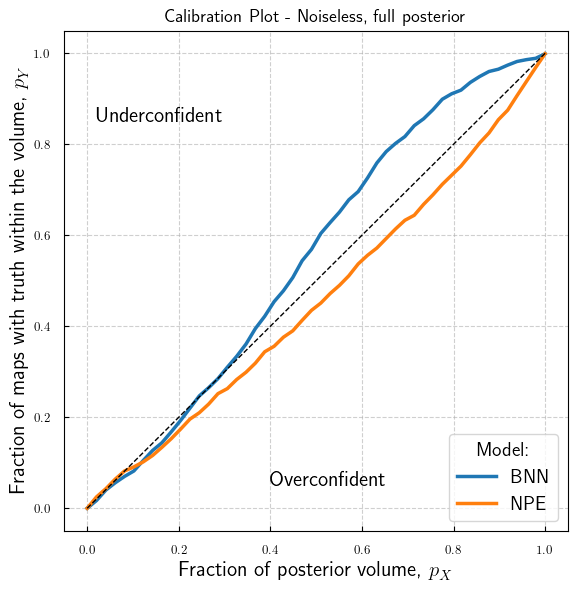

In [29]:
save_as = "Calibration_Plot_Comparison_full_noiseless"
title = 'Calibration Plot - Noiseless, full posterior'
make_calibration_plot(samples_BNN,samples_NPE,y_keep,save_as,title)

- And now calibration plots for noisy maps

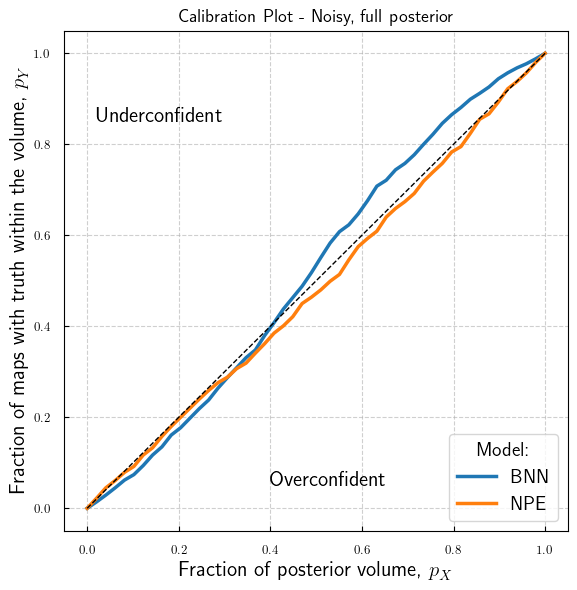

In [31]:
save_as = "Calibration_Plot_Comparison_full_noisy"
title = 'Calibration Plot - Noisy, full posterior'
make_calibration_plot(samples_BNN_NOISY,samples_NPE_NOISY,y_keep,save_as,title)

### Individual posterior plots

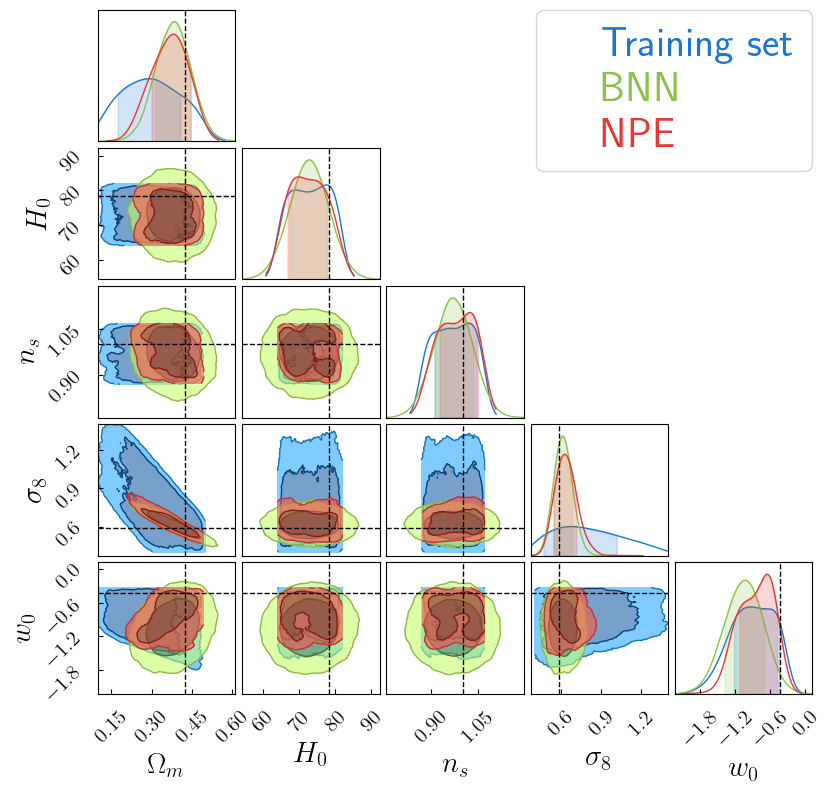

In [32]:
plot_posteriors(y_train,samples_BNN[100],samples_NPE[100],y_keep[100],"Example_Noiseless",full_posterior=True)

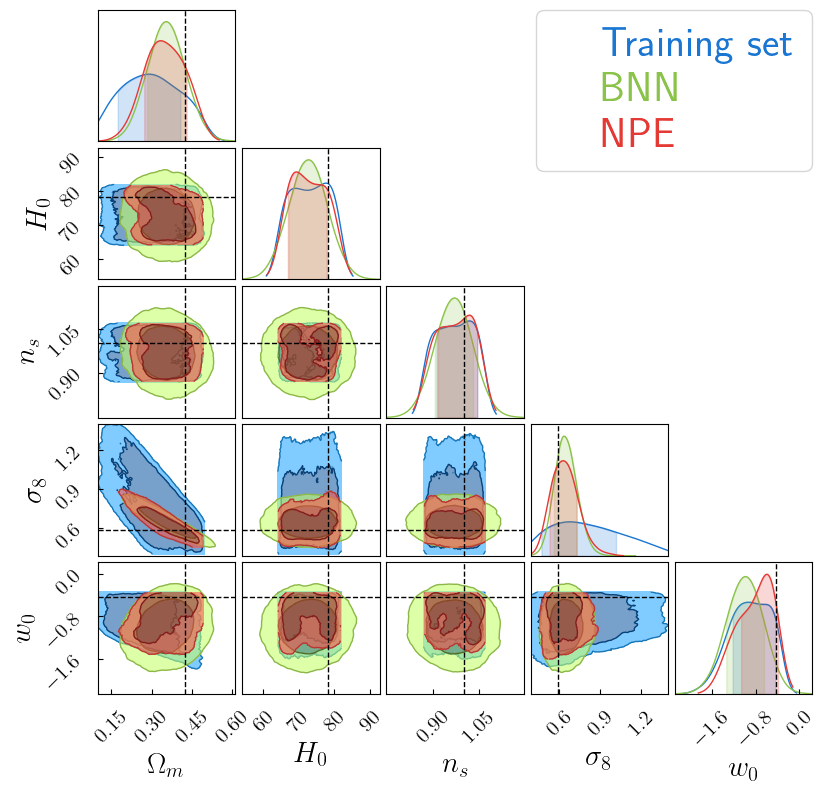

In [36]:
plot_posteriors(y_train,samples_BNN_NOISY[100],samples_NPE_NOISY[100],y_keep[100],"Example_Noisy",full_posterior=True)